In [26]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars
import numpy as np
import torch.nn.functional as F  # Import torch.nn.functional and alias it as F
import cv2 #Import cv2 for image resizing
import random
from torchvision import transforms
from PIL import ImageEnhance

# Data Loading and Preprocessing


In [27]:
# Define paths
data_dir = "./"  # Use raw string or escape backslashes
csv_path = os.path.join(data_dir, "pokemon.csv")
image_dir = os.path.join(data_dir, "images")

In [28]:
device = torch.device("cuda") # Force CPU usage

In [29]:
# Load the CSV
df = pd.read_csv(csv_path)

# Remove rows with missing 'Type1' values (if any)
df = df.dropna(subset=['Type1'])
df = df[df.Type1.isin(['Water','Grass','Fire'])][['Name','Type1']]

In [30]:
# Create a mapping from Pokemon name to image path using Pandas
df['image_path'] = df['Name'].apply(lambda name: os.path.join(image_dir, f"{name}.png"))

# Filter out rows where the image file doesn't exist using Pandas
df['image_exists'] = df['image_path'].apply(os.path.exists)
df = df[df['image_exists']]
df = df.drop('image_exists', axis=1)  # Remove the temporary column

In [31]:
df.head()

,Name,Type1,image_path
0,bulbasaur,Grass,./images\bulbasaur.png
1,ivysaur,Grass,./images\ivysaur.png
3,charmander,Fire,./images\charmander.png
4,charmeleon,Fire,./images\charmeleon.png
5,charizard,Fire,./images\charizard.png


In [32]:
# Prepare data for the dataset - now directly using DataFrame columns
data = df[['image_path', 'Type1']].rename(columns={'Type1': 'type1'}).to_dict('records') #Create list of dictionaries

#Create train, validation, and test splits using DataFrames
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Type1'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['Type1'])


In [33]:

# Convert DataFrames to lists of dictionaries for the Dataset
train_data = train_df[['image_path', 'Type1']].rename(columns={'Type1': 'type1'}).to_dict('records')
val_data = val_df[['image_path', 'Type1']].rename(columns={'Type1': 'type1'}).to_dict('records')
test_data = test_df[['image_path', 'Type1']].rename(columns={'Type1': 'type1'}).to_dict('records')


In [34]:

class RandomColorAugment:
    def __init__(self, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, img):
        if random.random() > 0.5:
            # Convert to PIL image if it's not already
            if not isinstance(img, Image.Image):
                img = transforms.ToPILImage()(img)
            
            # Apply random color transformations
            if random.random() > 0.5:
                factor = random.uniform(1-self.brightness, 1+self.brightness)
                img = ImageEnhance.Brightness(img).enhance(factor)
            if random.random() > 0.5:
                factor = random.uniform(1-self.contrast, 1+self.contrast)
                img = ImageEnhance.Contrast(img).enhance(factor)
            if random.random() > 0.5:
                factor = random.uniform(1-self.saturation, 1+self.saturation)
                img = ImageEnhance.Color(img).enhance(factor)
        return img


In [35]:
image_size = 224  # Standard size for VGG19
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        
        # More aggressive geometric transformations
        transforms.RandomHorizontalFlip(p=0.5),      # 50% chance to flip horizontally
        transforms.RandomVerticalFlip(p=0.3),        # 30% chance to flip vertically
        transforms.RandomRotation(degrees=180),       # Random rotation up to 180 degrees (more rotation!)
        
        # More aggressive affine transformations
        transforms.RandomAffine(
            degrees=45,                              # Increased rotation in affine transform
            translate=(0.2, 0.2),                    # Increased translation up to 20%
            scale=(0.8, 1.2),                        # More aggressive scaling
            shear=20                                 # Increased shearing
        ),
        
        # Perspective transformation
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        RandomColorAugment(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,
            hue=0.2
        ),
        # Color transformations
        transforms.RandomGrayscale(p=0.2),           # 20% chance to convert to grayscale
        transforms.ColorJitter(
            brightness=0.5,                          # Increased color jittering
            contrast=0.5,
            saturation=0.5,
            hue=0.3
        ),
        
        # Random cropping with resize
        transforms.RandomResizedCrop(
            image_size,
            scale=(0.7, 1.0),                       # Crop between 70-100% of original size
            ratio=(3./4., 4./3.)                    # Aspect ratio constraints
        ),
        
        transforms.ToTensor(),
        
        # Random erasing (like cutout)
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Pokemon Dataset


In [36]:
class PokemonDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.classes = sorted(list(set(item['type1'] for item in data))) # Extract classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image_path']).convert('RGB')  # Ensure images are RGB
        type1 = item['type1']
        label = self.class_to_idx[type1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

In [37]:
# Create instances of the Dataset
image_datasets = {
    'train': PokemonDataset(train_data, transform=data_transforms['train']),
    'val': PokemonDataset(val_data, transform=data_transforms['val']),
    'test': PokemonDataset(test_data, transform=data_transforms['test'])
}

In [38]:
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)

In [39]:
# Create DataLoaders
batch_size = 16  # Smaller batch size for CPU
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0), #num_workers=0 for CPU,
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=0 ),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
}

In [40]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes  # Get class names from the training dataset

In [41]:
print(f"Class names: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")
print(f"Number Classes: {len(class_names)}")

Class names: ['Fire', 'Grass', 'Water']
Dataset sizes: {'train': 132, 'val': 17, 'test': 17}
Number Classes: 3


# Model Training

In [42]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Add batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Add batch normalization
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjusted for 224x224 input
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Batch norm and ReLU
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Batch norm and ReLU
        x = x.view(-1, 32 * 56 * 56)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.x = self.dropout(x)
        x = self.fc2(x)
        return x
def get_resnet18(num_classes, pretrained=True):
    model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

    # Freeze all layers initially
    for param in model_ft.parameters():
        param.requires_grad = False

    # Get the number of input features for the last layer
    num_ftrs = model_ft.fc.in_features

    # Replace the last fully connected layer
    model_ft.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout layer
        nn.Linear(num_ftrs, num_classes)
    )

    # Unfreeze the FC layer
    for name, param in model_ft.named_parameters():
        if "fc" in name:
            param.requires_grad = True

    return model_ft
def get_vgg19(num_classes, pretrained=True):
    model_ft = models.vgg19(weights=models.VGG19_Weights.DEFAULT if pretrained else None)

    # Freeze all layers initially
    for param in model_ft.parameters():
        param.requires_grad = False

    # Get the number of input features for the last layer
    num_ftrs = model_ft.classifier[6].in_features

    # Replace the classifier with a new one
    model_ft.classifier[6] = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout layer
        nn.Linear(num_ftrs, num_classes)
    )

    # Unfreeze ONLY the classifier
    for name, param in model_ft.named_parameters():
        if "classifier" in name:
            param.requires_grad = True

    return model_ft
def get_squeezenet(num_classes, pretrained=True):
    model_ft = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT if pretrained else None)

    # Freeze all layers initially
    for param in model_ft.parameters():
        param.requires_grad = False

    # Modify the final convolutional layer
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model_ft.num_classes = num_classes

    # Unfreeze the last layer
    for name, param in model_ft.named_parameters():
        if "classifier" in name:
            param.requires_grad = True

    return model_ft

In [43]:
import torchvision.models as models
import torch.nn as nn

def get_shufflenetv2(num_classes, pretrained=True):
    model_ft = models.shufflenet_v2_x0_5(weights=models.ShuffleNet_V2_X0_5_Weights.DEFAULT if pretrained else None)

    # Freeze all layers initially
    for param in model_ft.parameters():
        param.requires_grad = False

    # Modify the final fully connected layer
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    # Unfreeze the last layer
    for name, param in model_ft.named_parameters():
        if "fc" in name:
            param.requires_grad = True

    return model_ft

In [44]:

model_name = "SqueezeNet"  # Choose "SimpleCNN", "ResNet18", "VGG19", or "SqueezeNet"

if model_name == "SimpleCNN":
    model_ft = SimpleCNN(num_classes=len(class_names))
elif model_name == "ResNet18":
    model_ft = get_resnet18(num_classes=len(class_names), pretrained=True)
elif model_name == "VGG19":
    model_ft = get_vgg19(num_classes=len(class_names), pretrained=True)
elif model_name == "SqueezeNet":
    model_ft = get_squeezenet(num_classes=len(class_names), pretrained=True)
elif model_name == "ShuffleNetV2":
    model_ft = get_shufflenetv2(num_classes=len(class_names), pretrained=True)
else:
    raise ValueError("Invalid model name")

model_ft = model_ft.to(device)

In [45]:

from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['Type1']),
    y=train_df['Type1'])

class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)  # Move to the same device as the model

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss() #OLD
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001)  # Only optimize unfrozen parameters

# Learning rate scheduler (ReduceLROnPlateau)
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) #OLD
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=3)


In [46]:
# Image Transforms
# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    best_acc = 0.0
    best_model_wts = model.state_dict()

    # Early stopping parameters
    patience = 5
    counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'val' and scheduler is not None: #CHANGED FOR REDUCELRONPLATEAU
                scheduler.step(epoch_loss)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history.setdefault(f'{phase}_loss', []).append(epoch_loss)
            history.setdefault(f'{phase}_accuracy', []).append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Checkpointing
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(), 'best_model.pth')  # Save best model weights
                counter = 0  # Reset early stopping counter
            elif phase == 'val':
                counter += 1
                if counter >= patience:
                    print("Early stopping triggered")
                    model.load_state_dict(best_model_wts)  # Load best weights
                    return model, history


        print()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


# Train


In [47]:

model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)



Epoch 0/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.87it/s]


train Loss: 1.3196 Acc: 0.4167


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.00it/s]


val Loss: 1.1358 Acc: 0.3529

Epoch 1/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.25it/s]


train Loss: 1.2093 Acc: 0.3485


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 63.19it/s]


val Loss: 1.1375 Acc: 0.2353

Epoch 2/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.61it/s]


train Loss: 1.1779 Acc: 0.2576


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 68.86it/s]


val Loss: 1.1385 Acc: 0.2353

Epoch 3/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.48it/s]


train Loss: 1.1151 Acc: 0.3864


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 70.04it/s]


val Loss: 1.0835 Acc: 0.2941

Epoch 4/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.26it/s]


train Loss: 1.1228 Acc: 0.3636


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 57.88it/s]


val Loss: 1.0536 Acc: 0.3529

Epoch 5/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.61it/s]


train Loss: 1.1062 Acc: 0.4470


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 54.70it/s]


val Loss: 1.0118 Acc: 0.4118

Epoch 6/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.00it/s]


train Loss: 1.0575 Acc: 0.4697


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 56.24it/s]


val Loss: 1.0021 Acc: 0.4118

Epoch 7/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.83it/s]


train Loss: 1.0683 Acc: 0.5227


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.20it/s]


val Loss: 0.9867 Acc: 0.4118

Epoch 8/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.83it/s]


train Loss: 1.0960 Acc: 0.4015


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 49.28it/s]


val Loss: 0.9648 Acc: 0.5294

Epoch 9/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.06it/s]


train Loss: 1.1124 Acc: 0.3864


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 56.81it/s]


val Loss: 1.0115 Acc: 0.5294

Epoch 10/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.88it/s]


train Loss: 1.0480 Acc: 0.4545


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 53.21it/s]


val Loss: 1.0120 Acc: 0.5294

Epoch 11/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.67it/s]


train Loss: 1.0240 Acc: 0.4318


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.54it/s]


val Loss: 1.0170 Acc: 0.5294

Epoch 12/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.87it/s]


train Loss: 1.0638 Acc: 0.4470


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 49.91it/s]


val Loss: 0.9784 Acc: 0.4706

Epoch 13/19
----------


train: 100%|█████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.07it/s]


train Loss: 1.0372 Acc: 0.4318


val: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 52.54it/s]

val Loss: 0.9769 Acc: 0.4706
Early stopping triggered


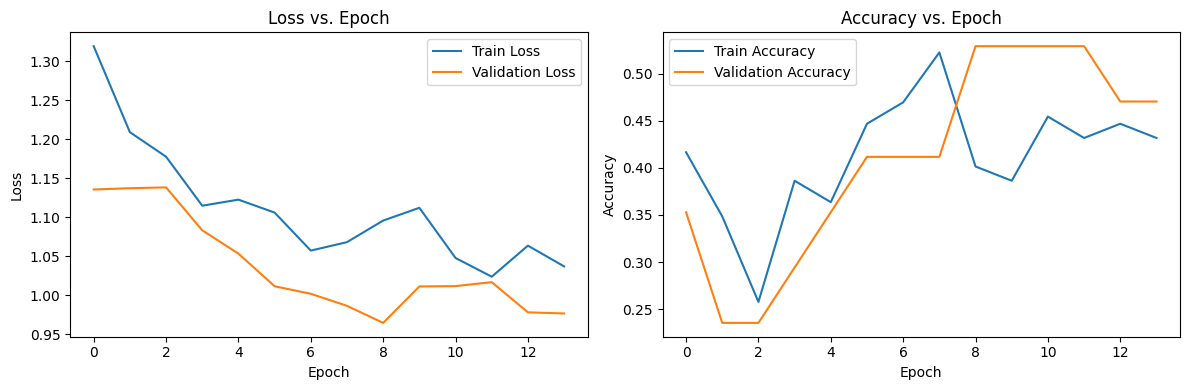

In [48]:

# print training on the TRAINING HISTORY set:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

plt.tight_layout()
plt.show()

In [50]:
# Evaluate on the TEST HISTORY: 
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    accuracy = running_corrects.double() / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

test_accuracy = evaluate_model(model_ft, dataloaders['test'])


Test Accuracy: 0.8235
